## Import Library

In [64]:
! pip install pmdarima

You should consider upgrading via the 'C:\Users\agnes\anaconda3\python.exe -m pip install --upgrade pip' command.


In [65]:
!pip install numpy

You should consider upgrading via the 'C:\Users\agnes\anaconda3\python.exe -m pip install --upgrade pip' command.


In [66]:
import pandas as pd
from statsmodels.tsa.seasonal import STL
from pylab import rcParams
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
from pmdarima.arima import auto_arima

## Load Data 

In [67]:
covidjkt = pd.read_csv('Dataset-IncrementRate-Covid-19.csv')
covidjkt

,Date,New Cases,Total Cases
0,2020-05-01,142,4317
1,2020-05-02,80,4397
2,2020-05-03,66,4463
3,2020-05-04,76,4539
4,2020-05-05,148,4687
...,...,...,...
271,2021-01-27,1836,256416
272,2021-01-28,2889,259305
273,2021-01-29,3448,262753
274,2021-01-30,3491,266244


## Data Preparation

In [68]:
IR = pd.Series(np.array((covidjkt['New Cases']/covidjkt['Total Cases'])*100))
IncrementRate = round(IR, 2)

In [69]:
covidjkt = covidjkt.assign(IncrementRate=IncrementRate.values)
covidjkt

,Date,New Cases,Total Cases,IncrementRate
0,2020-05-01,142,4317,3.29
1,2020-05-02,80,4397,1.82
2,2020-05-03,66,4463,1.48
3,2020-05-04,76,4539,1.67
4,2020-05-05,148,4687,3.16
...,...,...,...,...
271,2021-01-27,1836,256416,0.72
272,2021-01-28,2889,259305,1.11
273,2021-01-29,3448,262753,1.31
274,2021-01-30,3491,266244,1.31


In [70]:
covidjkt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276 entries, 0 to 275
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           276 non-null    object 
 1   New Cases      276 non-null    int64  
 2   Total Cases    276 non-null    int64  
 3   IncrementRate  276 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 8.8+ KB


In [71]:
covidjkt.set_index('Date', inplace=True)
covidjkt.head()

,New Cases,Total Cases,IncrementRate
Date,,,
2020-05-01,142,4317,3.29
2020-05-02,80,4397,1.82
2020-05-03,66,4463,1.48
2020-05-04,76,4539,1.67
2020-05-05,148,4687,3.16


In [72]:
covidjkt = covidjkt.asfreq(pd.infer_freq(covidjkt.index))

In [73]:
ir = covidjkt.copy()
ir = covidjkt.drop(['Total Cases', 'New Cases'], axis =1)
ir

,IncrementRate
Date,
2020-05-01,3.29
2020-05-02,1.82
2020-05-03,1.48
2020-05-04,1.67
2020-05-05,3.16
...,...
2021-01-27,0.72
2021-01-28,1.11
2021-01-29,1.31


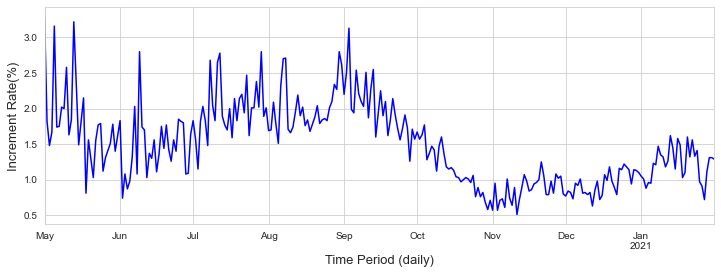

In [74]:
covidjkt['IncrementRate'].plot(figsize = (12,4), color='blue')
# plt.title('Increment Covid JKT', fontsize=16)
plt.ylabel('Increment Rate(%)', fontsize=13)
plt.xlabel('Time Period (daily)', fontsize=13)
plt.show()

## Split Train & Test Data

In [75]:
#Train data to be used in the STL Decomposition and STL-SARIMA models
#The test data will be used in the Value-at-Risk method.

#90:10
X = ir
Xtrain = X[:240] #Train data
Xtest = X[240:] #Test data

In [76]:
Xtrain

,IncrementRate
Date,
2020-05-01,3.29
2020-05-02,1.82
2020-05-03,1.48
2020-05-04,1.67
2020-05-05,3.16
...,...
2020-12-22,0.79
2020-12-23,1.16
2020-12-24,1.14


In [77]:
Xtest

,IncrementRate
Date,
2020-12-27,1.14
2020-12-28,0.94
2020-12-29,1.14
2020-12-30,1.13
2020-12-31,1.10
2021-01-01,1.05
2021-01-02,1.01
2021-01-03,0.88
2021-01-04,0.96


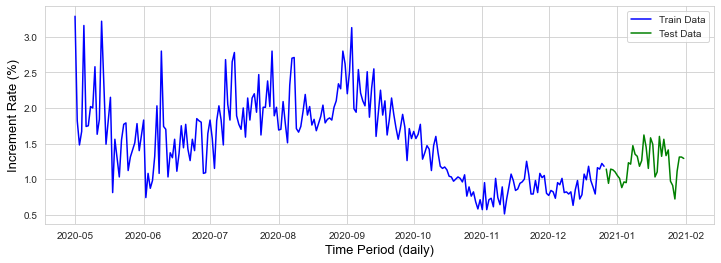

In [90]:
plt.figure(figsize=(12,4))
plt.plot(Xtrain, label="Train Data", color='blue')
plt.plot(Xtest, label="Test Data", color='green')
plt.ylabel('Increment Rate (%)', fontsize=13, color='black')
plt.xlabel('Time Period (daily)', fontsize=13, color='black')
plt.legend()
plt.show()

## Data Analysis using STL Decomposition Model

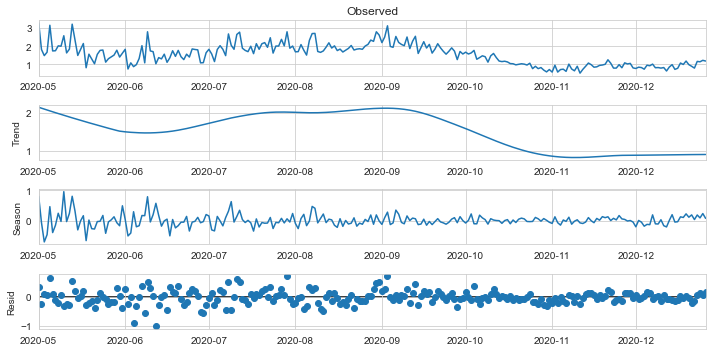

In [79]:
stl = STL(Xtrain, period=30, seasonal=7, robust=False)
result = stl.fit()

rcParams['figure.figsize']=10,5
result.plot()
plt.show()

In [80]:
seasonal, trend, resid = result.seasonal, result.trend, result.resid

In [81]:
result.seasonal

Date
2020-05-01    0.799444
2020-05-02   -0.071433
2020-05-03   -0.705667
2020-05-04   -0.466699
2020-05-05    0.458963
                ...   
2020-12-22    0.032436
2020-12-23    0.183451
2020-12-24    0.087666
2020-12-25    0.231104
2020-12-26    0.072818
Freq: D, Name: season, Length: 240, dtype: float64

In [82]:
result.trend

Date
2020-05-01    2.142119
2020-05-02    2.118315
2020-05-03    2.094673
2020-05-04    2.071200
2020-05-05    2.047903
                ...   
2020-12-22    0.911503
2020-12-23    0.912032
2020-12-24    0.912561
2020-12-25    0.913100
2020-12-26    0.913654
Freq: D, Name: trend, Length: 240, dtype: float64

In [83]:
result.resid

Date
2020-05-01    0.348437
2020-05-02   -0.226881
2020-05-03    0.090995
2020-05-04    0.065499
2020-05-05    0.653134
                ...   
2020-12-22   -0.153938
2020-12-23    0.064518
2020-12-24    0.139772
2020-12-25    0.075796
2020-12-26    0.193529
Freq: D, Name: resid, Length: 240, dtype: float64

## Additive Model STL

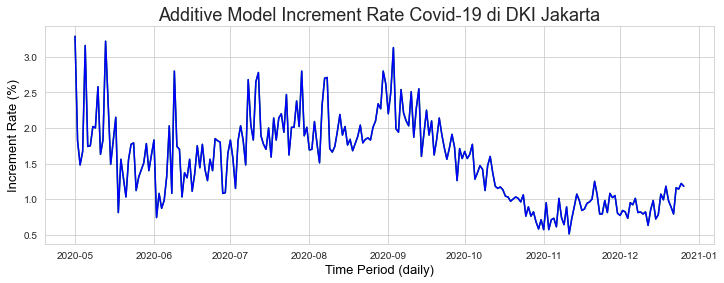

In [89]:
additiveModel = result.trend + result.seasonal + result.resid
plt.figure(figsize=(12,4))
plt.plot(Xtrain, color='green')
plt.plot(additiveModel, color='blue')
plt.title('Additive Model Increment Rate Covid-19 di DKI Jakarta', fontsize=18)
plt.ylabel('Increment Rate (%)', fontsize=13, color='black')
plt.xlabel('Time Period (daily)', fontsize=13, color='black')
plt.show()

## Best Model Selection

In [85]:
stepwise_model = auto_arima(ir, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.54 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=422.965, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=323.388, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.42 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=382.667, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=309.226, Time=0.37 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.65 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.79 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=354.478, Time=0.17 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=289.129, Time=0.56 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=304.546, Time=0.21 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=2.24 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.08 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=266.305, Time=0.74 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=279.843, Time=

## Forecasting SARIMA

In [87]:
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA

stlf = STLForecast(Xtrain, ARIMA, model_kwargs=dict(order=(0,1,2), trend="t"), robust=True).fit()
forecast = stlf.forecast(36)

In [88]:
print(stlf.summary())

                    STL Decomposition and SARIMAX Results                     
Dep. Variable:                      y   No. Observations:                  240
Model:                 ARIMA(0, 1, 2)   Log Likelihood                 -83.659
Date:                Fri, 14 May 2021   AIC                            175.317
Time:                        16:20:27   BIC                            189.223
Sample:                    05-01-2020   HQIC                           180.921
                         - 12-26-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0052      0.006     -0.832      0.405      -0.017       0.007
ma.L1         -0.6612      0.051    -13.059      0.000      -0.760      -0.562
ma.L2         -0.1133      0.051     -2.217      0.0